# Project

In [1]:
student_name = 'Salih Kilicli'

## Overview

In this project you will implement Kruskal's algorithm with path compression to find an approximation to the Traveling Salesman Problem.  You will be given a complete undirected graph with weights, and you will be expected to produce a minimum spanning tree along with a preorder traversal.

## Instructions

1. Complete the function `sort_edges` to sort the edges, in place, in non-decreasing order according to their weights.

1. Complete the function `init_tree_lookup` to return the tree lookup table for all vertices in the graph.  

1. Complete the function `find_set` to find and return the index of the root vertex for the tree containing the passed vertex index, while updating the table's parent indices using path compression. 

1. Complete the function `union` to merge two trees in the lookup table.

1. Complete the function `find_MST_Kruskal` using the functions above.

1. Complete the function `preorder`, which should return the nodes in the tree exactly once in the order in which they are encountered.

1. Complete the function `compute_path_weight` to sum the weights of the edges as they would be traversed according to `preorder`.

1. Answer the questions in the Understanding section.

1. Run the code blocks for the real world application of your above solutions.

## Submitting Your Assignment

You will submit your completed assignment in two formats:

- Jupyter Notebook (.ipynb)
- HTML (.html)

##### Jupyter Notebook (.ipynb)
You may directly use this notebook to complete your assignment or you may use an external editor/IDE of your choice.  However, to submit your code please ensure that your code works in this notebook.  
  
##### HTML (.html)
To create an HTML file for your assignment simply select `File > Download as > HTML (.html)` from within the Jupyter Notebook.  
  
Both files should be uploaded to [Canvas](https://canvas.tamu.edu).

## Installing Required Packages

For this project we will be using several modules, some of which are not included in a standard installation of Python and/or Anaconda.

For Linux and Mac users the following instructions can be performed in any shell of your choosing.  For Windows users the instructions are written for use in the `Anaconda Powershell Prompt (anaconda3)` application.

We will use the conda package installer to help us acquire and install necessary packages.  One could also use pip the Python Package Installer, but the instructions below will only be given for conda.  A common error made by those new to anaconda and/or python is to install pacakges using the wrong pacakge manager, as there may be multiple versions of conda, python etc on their system.  Before installing the packages below be sure to first identify the correct conda (or pip).  For Linux and Mac we will assume that Anaconda was installed locally in your home directory and the bin directory is located at `~/opt/anaconda3/bin/` (Verify the location on your system in the event your installation/setup is different).  For Windows users we will assume you are using the `Anaconda Powershell Prompt (anaconda3)` application.  The instructions below assume that the correct conda can be found in your path, however you can always use the full or relative path for your system (e.g. `~/opt/anaconda3/bin/conda`).

Install the following packages before attempting to complete project.


### Folium 

1. `conda install -c conda-forge folium`


### BaseMap


BaseMap may not be found in using pip, so we use conda.  This may take several attempts by conda, which is fine.  It will likely prompt you concerning the installation of a few dependencies (geos, proj4, ...) which should be installed.

1. `conda install basemap`


### OpenRouteService

1. `conda install -c nilsnolde openrouteservice`

To use the OpenRouteService client interface you will need to acquire an API key.  Acquiring a key is optional as it requires you to sign up for a free account with [OpenRouteService](https://openrouteservice.org/dev/#/signup).  To get an API key do the following:

1. Sign up for an account at [OpenRouteService](https://openrouteservice.org/dev/#/signup).

1. Log in to your account, and click on Dashboard to take you to the 'Dev dashboard', be sure you are on the 'Tokens' tab of the Dev dashboard.

1. Find the section labeled 'Request a token' near the bottom of the page.

1. Click on 'Token type*' and select Free.

1. Click on 'Token name*' and enter a name for the token, e.g. 'Test Token'.

1. Click the button 'Create Token'.

1. On the Tokens tab of the Dev dashboard you should see a long string or seemingly random characters an numbers, this is your API key.  Click on the key to copy it to the clipboard.

1. Later in this notebook there is a code block containing `api_key=None`.  Replace `None` with a string containing your API key. 





## Imports

In [2]:
import numpy as np

# GIS Shapefile loader
import shapefile

# Map and map layers
import folium

# Driving and distance queries
from openrouteservice import client, convert, distance_matrix

# Plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
import matplotlib.patches as patches
import matplotlib.animation
from IPython.display import HTML

### Fix the random initialization

In [3]:
# set seed to reproduce the data given by pseudo-random number generator

np.random.seed(42)

## Helper Functions

In [4]:
def distance(i, j, vertices):
    """
    Computes the distance between vertices[i] and vertices[j].
    i,j - Indices of nD points in vertices.
    vertices - An np.array containing nD points.
    Returns - The distance between the indexed points.
    """
    if i == j:
        return np.NaN
    d = np.array(vertices[i]) - np.array(vertices[j])
    return np.sqrt(d.dot(d))


def create_random_graph(cnt=10):
    """
    Creates a complete undirected graph containing `cnt` 2D random vertices.
    cnt - The number of 2D vertices to be randomly generated for the graph.
    Returns - (vertices, edges), where vertices is a np.array of 2D random
            points, and edges is a list of tuples (i, j, w) where i and j are
            indices into the vertex array, vertices, and w is the weight or
            2D distance between vertices[i] and vertices[j].
    """
    vertices = np.random.uniform(low=-10, high=10, size=(cnt,2))
    edges = [(i, j, distance(i, j, vertices)) 
         for i in range(cnt) 
         for j in range(i+1, cnt)]
    return (vertices, edges)


def plot_graph(vertices, edges, highlight_idx=None):
    """
    Plots the graph with edges.
    vertices - An np.array containing the 2D vertices of the graph.
    edges - A list of edge tuples (i, j, w) where i and j are indices into 
            vertices, and w is the weight of the edge connecting the 
            vertices, vertices[i] and vertices[j]. 
    """
    fig = plt.figure(figsize=(10, 8))

    plt.scatter(vertices[:, 0], vertices[:, 1], marker='o', color='blue', s=250)

    if edges is not None:
        for edge in edges:
            ev_x = [vertices[edge[0]][0], vertices[edge[1]][0]]
            ev_y = [vertices[edge[0]][1], vertices[edge[1]][1]]
            plt.plot(ev_x, ev_y, color='black', zorder=-1)
            for (i, (x, y)) in enumerate(vertices):
                plt.text(x, y, str(i), color = 'white', ha='center', va='center', fontsize=11)

            
    if highlight_idx is not None:
        plt.scatter(vertices[highlight_idx,0], vertices[highlight_idx,1], marker='D',color='red', s=250)
    
    plt.show()


def naive_center(coords):
    """
    Computes a centroid of the passed 2D coordinates.
    coords - A list of 2D points.
    Returns - (a,b) where a and b are the mean of their respective coordinates.
    """
    return (np.mean([a[0] for a in coords]), np.mean([a[1] for a in coords]))


def in_bounding_box(center, bounds, point):
    """
    Returns True if point is inside or on the boundary of a box centered at 
    center with extents, bounds, and False otherwise.
    center - A 2D point representing the center of a axis-aligned box.
    bounds - The horizontal and vertical half-extents of the axis-aligned box.
    point - A 2D point to be tested against the box for containment.
    Returns - True if point is inside or on the boundary of a box centered at 
            center with extents, bounds, and False otherwise.
    """
    return ((center[0]-bounds[0]) <= point[0] <= (center[0]+bounds[0]) and 
            (center[1]-bounds[1]) <= point[1] <= (center[1]+bounds[1]))
    

def load_business_locations_by_class(shape_file, map_center, bound_box, landmark_class='BAR'):
    """
    Loads a shape file and returns all businesses whose landmark class matches the
    passed class. Business locations that are outside of the passed region, 
    represented by map_center and bound_box, are culled from the returned list.
    shape_file - The path and file name of a shapefile containing fields as 
            described by https://data-cstx.opendata.arcgis.com/datasets/structures.
    map_center - The latitude and longitude of the center of the region of interest. 
    bound_box - The half-extents of a 'box' centered at map_center that defines the
            region of interest.  This box is used to cull business outside of the
            region.
    landmark_class - A string representing the class of the landmark to be returned
            by this function.  See the City of College Station GIS page for more 
            information.
    Returns - A list of dictionaries containing the occupant, name, building 
            footprint polygon, building location (center), and the shapefile record
            for the buisness.
    """
    reader = shapefile.Reader(shape_file)
    fields = reader.fields[1:]
    field_names = [field[0] for field in fields]

    location_data = []
    for sr in reader.shapeRecords():
        if landmark_class == sr.record[field_names.index('LANDMARK_C')]:
            rec = dict(zip(field_names, sr.record))
            geom = sr.shape.__geo_interface__
            poly = [(b,a) for a,b in geom['coordinates'][0]]
            cen = naive_center(poly)
            name = rec['OCCUPANT']
            if in_bounding_box(map_center, bound_box, cen):
                location_data.append(dict(name=name, geometry=poly, center=cen, record=rec))
    return location_data


def plot_location_data(location_data, map_center, graph=None, directions=None, draw_markers=False):
    """
    Plots a map centered at map_center.
    location_data - A list of dictionaries containing the occupant, name, building 
            footprint polygon, building location (center), and the shapefile record
            for the buisness.
    map_center - The latitude and longitude of the center of the region of interest. 
    graph - A tuple containing the vertices and edges of a graph.
    directions - A direction dictionary returned from OpenRouteService Client.directions.
    draw_markers - Flag.  If True a clickable marker will be drawn at each location
            containing the name and lat,long of the location.
    """
    m = folium.Map(location=map_center, zoom_start=14) 

    for location in location_data:
        folium.vector_layers.Polygon(location['geometry'],
                                     color='#0000FF',
                                     fill_color='#0000FF',
                                     fill_opacity=1,
                                     weight=3).add_to(m)
        if draw_markers:
            name = location['name']
            lat,lon = location['center']
            popup = "<strong>{0}</strong><br>Lat: {1:.3f}<br>Long: {2:.3f}".format(name, lat, lon)
            icon = folium.map.Icon(color='gray',
                                icon_color='white',
                                icon='beer', # fetches font-awesome.io symbols
                                prefix='fa')
            folium.map.Marker([lat, lon], icon=icon, popup=popup).add_to(m)

        if graph:
            vertex_list = graph[0]
            edge_list = graph[1]
            for edge in edge_list:
                line = [[vertex_list[edge[0]][1],vertex_list[edge[0]][0]],
                        [vertex_list[edge[1]][1],vertex_list[edge[1]][0]]]
                folium.PolyLine(line, color='red', weight=3).add_to(m)
        if directions:
            geometry = directions['routes'][0]['geometry']
            decoded_path = convert.decode_polyline(geometry)
            path_coords = [[p[1], p[0]] for p in decoded_path['coordinates']]
            folium.PolyLine(path_coords, color='green', weight=3).add_to(m)
            
    display(m)  

def create_graph_from_business_locations(location_data, api_key=None):
    """
    Creates a complete undirected weighted graph from the passed location data.
    location_data - A list of dictionaries containing the occupant, name, building 
            footprint polygon, building location (center), and the shapefile record
            for the buisness.
    api_key - A user specific API key issued by OpenRouteService.  If None then 
            simple 2D straight line distances will be used in place of driving
            distance queries.  If a valid key is available then this function will
            query OpenRouteService for driving distances to weight each edge of
            the resulting graph.
    Returns - A graph whose vertices are business centers and a complete set of
            weighted edges.
    Note - Driving directions are not symmetric and so the distance in one 
            direction may differ in the opposite direction.  This function assumes
            these distances are symmetric and arbitrarily picks one of the two 
            distances for each edge in a consistent manner.  This is done because
            the graph returned is required to be undirected.    
    """
    
    if api_key is None:
        print('''
         ***********************************************************************
         No API Key was passed to this function.  This function will not be able
         query OpenRouteService for driving distances between business locations
         and will instead use the 2D distance function to compute weights.
         ***********************************************************************
              ''')
    
    map_vertices = [(location['center'][1],location['center'][0]) 
                    for location in location_data]
    
    if api_key:
        clnt = client.Client(key=api_key)

        request = {'locations': map_vertices,
                   'profile': 'driving-car',
                   'metrics': ['distance'],
                   'units': 'km',
                   'resolve_locations': True,
                   'dry_run': False}

        location_matrix = clnt.distance_matrix(**request)
        
        # edges - assume the distance matrix is symmetric 
        #       - even though this is not the case
        map_edges = [(i,j,location_matrix['distances'][i][j]) 
                     for i in range(len(map_vertices)) 
                     for j in range(i+1, len(map_vertices))]

    else:
        map_edges = [(i,j,distance(i,j,map_vertices)) 
                     for i in range(len(map_vertices)) 
                     for j in range(i+1,len(map_vertices))]
        
    return (map_vertices, map_edges)
        
    
def query_driving_directions(map_vertices, path, api_key=None):
    """
    Queries OpenRouteService for directions going through every point along the
    specified path.
    map_vertices - A list of vertices (locaitons)
    path - A list of indices of vertices (map_vertices) that give the set of
            waypoints, in order, that the driving directions must go through.            
    api_key - A user specific API key issued by OpenRouteService.  If None then 
            simple 2D straight line distances will be used in place of driving
            distance queries.  If a valid key is available then this function will
            query OpenRouteService for driving distances to weight each edge of
            the resulting graph.
    Returns - A directions dictionary.
    """
    if api_key is None:
        print('''
         ************************************************************************
         No API Key was passed to this function.   This function will not be able
         query OpenRouteService for driving directions between business locations
         and will return None.
         ************************************************************************
              ''')
        return None
    
    traversal_path = [map_vertices[idx] for idx in path]

    clnt = client.Client(key=api_key)
    directions = clnt.directions(traversal_path, profile='driving-car', preference='shortest')
    return directions

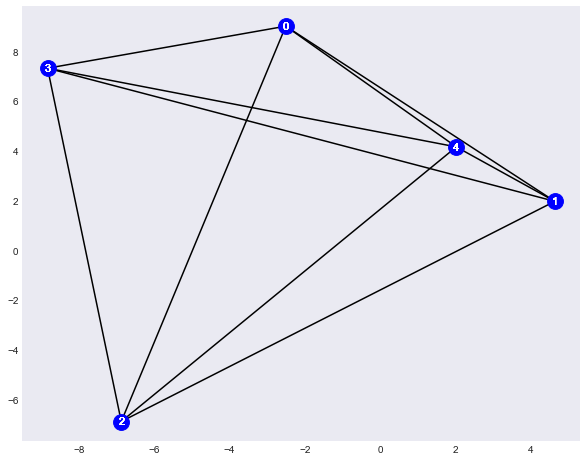

Vertices (v = (x, y)) :=
[[-2.509  9.014]
 [ 4.64   1.973]
 [-6.88  -6.88 ]
 [-8.838  7.324]
 [ 2.022  4.161]]

Edges (v1, v2, d) :=
[(0, 1, 10.034), (0, 2, 16.484), (0, 3, 6.551), (0, 4, 6.64), (1, 2, 14.529), (1, 3, 14.501), (1, 4, 3.412), (2, 3, 14.338), (2, 4, 14.183), (3, 4, 11.312)]

Center (mean(V)):=
(-2.3129999999999997, 3.1184000000000003)


In [5]:
(v, e) = create_random_graph(cnt=5)
e = [(i, j, round(w, 3)) for (i, j, w) in e]
v = v.round(3)
plot_graph(v, e, highlight_idx=None)
c = naive_center(v)

print(f'Vertices (v = (x, y)) :=\n{v}\n')
print(f'Edges (v1, v2, d) :=\n{e}\n')
print(f'Center (mean(V)):=\n{c}')

## Kruskal's Algorithm

The following pseudocode represents a high-level view of Kruskal's algorithm on a fully connected undirected weighted graph.

<br>
<div STYLE="background-color:#000000; height:2px; width:100%;"></div>
<b>Algorithm:</b> Kruskal's Algorithm
<div STYLE="background-color:#000000; height:1px; width:100%;"></div>

- <b>Input:</b> Complete undirected graph with weights $w$
- <b>Output:</b> A minimum spanning tree (MST)

<div STYLE="background-color:#000000; height:1px; width:100%;"></div>

1. Create a forest of trees, where each vertex is the root of a tree
2. Sort all edges in non-decreasing order, by weight
3. __While__ (there are fewer than $|V|-1$ edges in the MST):
4. $\quad$ Get the next edge from the sorted edges
5. $\quad$ __If__ (the edge connects two different trees):  
6. $\qquad$ Add the edge to the MST
7. $\quad$ __Else__:
8. $\qquad$ Discard the edge
9. __return__ The minimum spanning tree (MST)

<div STYLE="background-color:#000000; height:2px; width:100%;"></div>
<br>

The goal of the algorithm is to merge the forest of trees using the smallest weight edges in a greedy fashion such that no cycles are introduced and the resulting tree spans the entire set of vertices with minimum total weight.  To do this the algorithm uses a disjoint-set data structure, which keeps track of the vertices of the graph partitioned into disjoint subsets (the forest of trees).  

Initially, all vertices begin in their own tree (Line 1), that is to say we partition the set of vertices into $|V|$ disjoint subsets.  Line 2 ensures that we try each edge from small to large.  The while loop on Line 3 needs only continue until there are exactly $|V|-1$ edges, because we know that the MST will contain exactly that number of edges.  To process lines 5 through 8 above we will use the `Union-Find` algorithm with our disjoint-set data structure.  The `Union-Find` performs two basic operations:

1. **FIND**: Determines to which subset (tree) an element (vertex in the graph) belongs.  
1. **UNION**: Performs the union of two subsets.

**INIT**: Before we can implement the `Union-Find` algorithm we will require a data structure to represent the disjoint subsets (trees).  For this purpose we will use a lookup table that enables identification of the root of the tree to which a queried vertex belongs.  This lookup table will be implemented as a dictionary, where the keys are indices of the vertices in our graph and the values are lists containing two elements, (1) the index of the 'parent' vertex and (2) the 'rank' of the tree (set).  Rank will be defined later.  The data structure enables identification of the root of a tree to which a vertex belongs through traversal of 'parent' links until the root is found.

**FIND**: The find operation recursively traverses the parent links to find the root of the tree, which is the vertex who is its own parent.  The index of the root vertex is returned.  In this implementation of the FIND operation it will also perform path compression as part of the traversal, in that the implementation will update the parent indices to the root index as the recursion unwinds.  

**UNION**: This operation uses **FIND** to determine the roots of the two trees to be merged.  If the two roots are the same no merging is necessary.  Otherwise it will *attach* the shorter tree to the taller using rank to determine which is taller.  Doing this ensures that the resulting tree is no taller than either input unless the ranks were equal in which case the the tree becomes taller by one node.  To attach one tree to another we set the parent index of the root of the shorter tree (smaller rank) to the index of the root of the taller tree (larger rank).  If the trees both have equal rank then we set the parent index of the root of the second tree to the index of the root in the first tree and increment the rank of the first tree.

**Path Compression**: The idea of path compression is to *flatten* the tree when `find_set` is called.  When the find operation traverses the tree it returns the root index for that tree.  Path compression creates shortcuts that are stored in the lookup table preventing the traversal of intermediate nodes in the tree.  These shortcuts are realized by the values stored in the parent indices.

**Rank**: In the description above the idea of rank and the height of a tree are used interchangeably.  So why use rank and not simply height?  The term rank is preferred in this case because of the use of path compression where the computation of height is not exact due to the skipping of levels in the tree.




## Your Solution(1): Sort Weighted Edges

Complete the function `sort_edges` to sort the edges, in place, in non-decreasing order according to their weights.  **HINT**: Read the section on sorting [Key Functions](https://docs.python.org/3/howto/sorting.html#key-functions).

In [6]:
def sort_edges(edges):
    """
    Performs an in-place sort (non-decreasing order) of the passed edges list.
    edges - A list of tuples (i, j, w) where i and j are indices into a vertex
            array, and w is the weight of the edge connecting vertex i and 
            vertex j.
    Notice edges is a list of tuples so we have to select the last element of each tuple
    """
    
    return sorted(edges, key=lambda tuples: tuples[-1])

In [7]:
# Testing the sort_edges function

print(f'Unsorted version:\n\n{e}\n')
print(f'Sorted version:\n\n{sort_edges(e)}')

Unsorted version:

[(0, 1, 10.034), (0, 2, 16.484), (0, 3, 6.551), (0, 4, 6.64), (1, 2, 14.529), (1, 3, 14.501), (1, 4, 3.412), (2, 3, 14.338), (2, 4, 14.183), (3, 4, 11.312)]

Sorted version:

[(1, 4, 3.412), (0, 3, 6.551), (0, 4, 6.64), (0, 1, 10.034), (3, 4, 11.312), (2, 4, 14.183), (2, 3, 14.338), (1, 3, 14.501), (1, 2, 14.529), (0, 2, 16.484)]


## Your Solution (2): Disjoint-set

Complete the function `init_tree_lookup` to return the tree lookup table (a dictionary) for all vertices in the graph.  

In [8]:
def init_tree_lookup(vertices):
    """
    Creates a lookup table to help quickly identify to which tree the vertex
    belongs.  This is to be done be traversing the parents until the root of
    the tree is found.  This data structure also supports path compression 
    in that the 'parent' index stored for a given vertex is not required to 
    be a direct parent and may be an ancestor farther up the tree.  This
    allows 'Find' algorithms to more quickly identify vertices that belong 
    to the same tree.
    vertices - An np.array of 2D vertices to be used as the roots of the
            forest of trees.
    Returns - A dictionary whose keys are the indices of the passed 
            vertices and values are two element lists containing the index
            of the 'parent' and the rank of the tree.  
    """
    
    n = len(vertices)
    d = {}
    for i in range(n):
        d.update({i: [i, 0]})
        
    return d

In [9]:
# testing init_tree_lookup() function

print(f'vertices:=\n\n{v}\n')
lookup_table = init_tree_lookup(v)
print(f'lookup_table:=\n\n{lookup_table}')

vertices:=

[[-2.509  9.014]
 [ 4.64   1.973]
 [-6.88  -6.88 ]
 [-8.838  7.324]
 [ 2.022  4.161]]

lookup_table:=

{0: [0, 0], 1: [1, 0], 2: [2, 0], 3: [3, 0], 4: [4, 0]}


## Your Solution (3): Find-set

Complete the function `find_set` to find and return the index of the root vertex for the tree containing the passed vertex index, while updating the table's parent indices using path compression. 

In [10]:
def find_set(lookup_table, v_idx):
    """
    Recursively finds the root of the tree containing v_idx, and performs path 
    compression as part of the traversal.  The lookup_table is modified such 
    that parent values for all nodes along the path from v_idx to the root are 
    updated to point to be the root index.
    lookup_table - A dict whose keys are vertex indices, e.g. v_idx, and values
            are two element lists containing the parent index and rank of the 
            tree.
    v_idx - The index of the vertex whose containing tree is to be identified.
    Returns - The index of the root of the tree containing the vertex 
            corresponding to the passed v_idx.       
    """
    
    if lookup_table[v_idx][0] == v_idx:
        return v_idx
    
    return find_set(lookup_table, lookup_table[v_idx][0])

In [11]:
# lookup_table() func test

for i in range(len(v)):
    print(f'{find_set(lookup_table, i)} is the root of {i}-th vertex')

0 is the root of 0-th vertex
1 is the root of 1-th vertex
2 is the root of 2-th vertex
3 is the root of 3-th vertex
4 is the root of 4-th vertex


## Your Solution (4): Union

Complete the function `union` to merge two trees in the lookup table.

In [12]:
def union(lookup_table, u_idx, v_idx):
    """
    Merges the trees containing the vertices identified by u_idx and v_idx.
    This operation uses find_set to determine the roots of the two trees to be 
    merged.  If the two roots are the same no merging is necessary and the 
    function returns.  If the rank of the u_idx tree is greater than the rank 
    of the v_idx tree then the v_idx tree root is updated to be the root of the 
    u_idx tree, and vice versa.  If the ranks are equal then the root of the 
    v_idx tree is set to the root of the u_idx tree and the rank of the u_idx
    tree is incremented by one.
    lookup_table - A dict whose keys are vertex indices, e.g. v_idx, and values
            are two element lists containing the parent index and rank of the 
            tree.
    u_idx - The index of the vertex whose containing tree is to be merged with
            the tree of v_idx.
    v_idx - The index of the vertex whose containing tree is to be merged with 
            the tree of u_idx.
    """
     
    root_u = find_set(lookup_table, u_idx)
    rank_u = lookup_table[u_idx][1]
    
    root_v = find_set(lookup_table, v_idx)
    rank_v = lookup_table[v_idx][1]
    
    if root_u != root_v:
        
        if rank_u > rank_v:
            lookup_table[v_idx][0] = root_u

        elif rank_v > rank_u:
            lookup_table[u_idx][0] = root_v

        else:
            lookup_table[v_idx][0] = root_u
            lookup_table[u_idx][1]  += 1

In [13]:
# union() func test
# since edge_root = edge_idx -> (No union) None

for i in range(len(v)-2):
    for j in range(len(v)-2):
        print(f'{union(lookup_table, i, j)}')

None
None
None
None
None
None
None
None
None


## Your Solution(5): Kruskal's Algorithm 

Complete the function `find_MST_Kruskal` using the functions above.

In [14]:
def find_MST_Kruskal(vertices, edges):
    """
    Uses Kruskal's algorithm with path compression to find and return the
    minimum spanning tree, MST, of the passed graph (vertices, edges).
    vertices - An np.array containing the 2D vertices of the graph.
    edges - A list of edge tuples (i, j, w) where i and j are indices into 
            vertices, and w is the weight of the edge connecting the 
            vertices, vertices[i] and vertices[j]. 
    Returns - mst_edges, root_idx, where mst_edges is a list of edge 
            tuples (i, j, w) copied from the input edges, and root_idx is
            the index of the root of the MST.
            
    Create a forest of trees, where each vertex is the root of a tree
    Sort all edges in non-decreasing order, by weight
    While there are fewer than |V|-1 edges in the MST:

     Get the next edge from the sorted edges
     If the edge connects two different trees:
         Add the edge to the MST
     Else:
         Discard the edge return The minimum spanning tree (MST)   
    """
    
    mst_edges    = []
    edges_sorted = sort_edges(edges)
    dic = init_tree_lookup(vertices)
    
    N = len(vertices)
    i, e = 0, 0
    
    while e < N-1:
        u, v, w = edges_sorted[i]
        i = i + 1
        root_u = find_set(dic, u)
        root_v = find_set(dic, v)
        
        if root_u != root_v:
            e = e + 1
            mst_edges.append([u, v, w])
            union(dic, root_u, root_v)
            # To see unions at each step uncomment below
            #plot_graph(vertices, mst_edges)
        
    return mst_edges, find_set(dic, mst_edges[0][0])

## Test Code: Random Graph Creation

Run the following code block to generate a random graph.

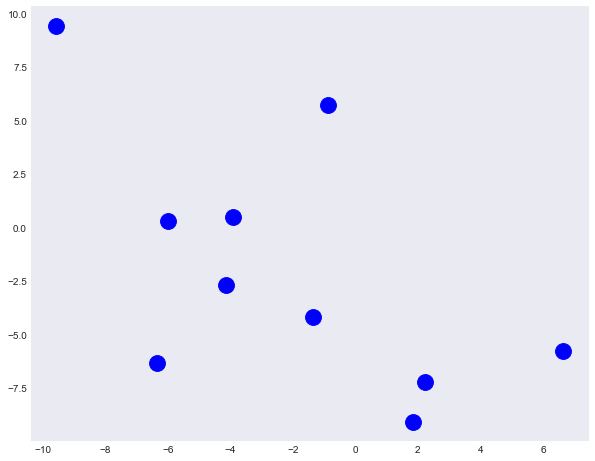

In [15]:
# The number of vertices that the graph will contain
num_vertices = 10

# Build a random complete undirected weighted graph
vertices, edges = create_random_graph(num_vertices)

# plot the vertices - the graph is fully connected - drawing that many edges is a mess
# if you wish to see the edges change None to edges below 
plot_graph(vertices, None)

## Test Code: Run Kruskal's Algorithm

Run the following code block to compute the minimum spanning tree from the graph `(vertices, edges)` using your implementation of `find_MST_Kruskal`.  The block also plots the result.  The MST should span the entire set of vertices.

The following code block uses `vertices`, `mst_edges` and `root_idx` computed above to create an animation showing the order in which each edge is added to the minimum spanning tree.  

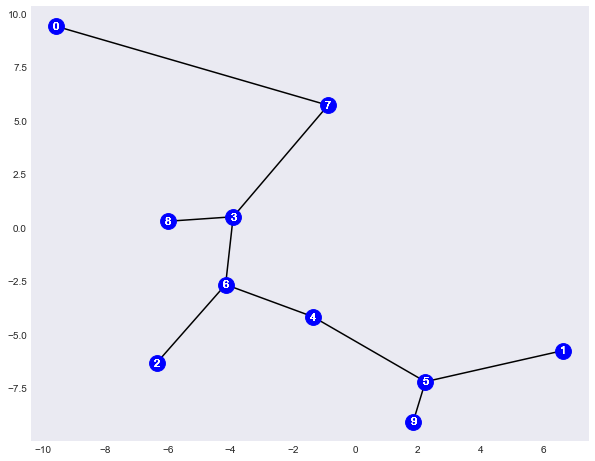

vertex-0: [-9.59  9.4 ]
vertex-1: [ 6.65 -5.75]
vertex-2: [-6.36 -6.33]
vertex-3: [-3.92  0.5 ]
vertex-4: [-1.36 -4.18]
vertex-5: [ 2.24 -7.21]
vertex-6: [-4.16 -2.67]
vertex-7: [-0.88  5.7 ]
vertex-8: [-6.01  0.28]
vertex-9: [ 1.85 -9.07]

MST_edges =[(5, 9, 1.9), (3, 8, 2.1), (4, 6, 3.17), (3, 6, 3.18), (2, 6, 4.27), (1, 5, 4.65), (4, 5, 4.71), (3, 7, 6.03), (0, 7, 9.46)]

Root_index = 3
lookup_table = {0: [0, 1], 1: [0, 0], 2: [0, 0], 3: [3, 0], 4: [4, 0]}


In [16]:
mst_edges, root_idx = find_MST_Kruskal(vertices, edges)

# plot the mst edges with the vertices
plot_graph(vertices, mst_edges)

for (i, v) in enumerate(vertices):
    print(f'vertex-{i}: {np.array(v).round(2)}')
    
print(f'\nMST_edges ={[(u, v, round(w, 2)) for (u, v, w) in mst_edges]}')
print(f'\nRoot_index = {root_idx}')
print(f'lookup_table = {lookup_table}')

In [17]:
last_edge_obj = None
# Create the figure
fig = plt.figure(figsize=(10, 5))
# draw the vertices
plt.scatter(vertices[:,0], vertices[:,1], marker='o', color='blue', s=250, zorder=-1)

def init():
    pass


def animate(frame_idx, vertices, edges, root_idx):
    """
    Draws the edges from index 0 to index frame_idx, along with the vertices.  
    When frame_idx exceeds the number of available edges the vertex identified
    by root_idx will be displayed in red and larger than the other vertices.
    The animation figure is closed after the root vertex is displayed.
    """
    global last_edge_obj
    
    if last_edge_obj is not None:
        # update the color on the last added edge
        last_edge_obj.set_color('gray')

    edge = edges[frame_idx] if frame_idx < len(edges) else None
    
    if edge is not None:
        # draw the new edge
        ev_x = [vertices[edge[0]][0], vertices[edge[1]][0]]
        ev_y = [vertices[edge[0]][1], vertices[edge[1]][1]]
        last_edge_obj = plt.plot(ev_x, ev_y, color='red', zorder=-2)[0]
        for (i, (x, y)) in enumerate(vertices):
            plt.text(x, y, str(i), color = 'white', ha='center', va='center', weight='bold', fontsize=11)

    else:
        # draw the root node of the tree
        plt.scatter(vertices[root_idx,0], vertices[root_idx,1], marker='D' ,color='red', s=250)
        plt.close()
    
    
# Create the animation
ani = matplotlib.animation.FuncAnimation(fig, 
                                         animate,
                                         interval = 600,
                                         frames=num_vertices, 
                                         fargs=(vertices, mst_edges, root_idx),
                                         init_func=init)
# Generate HTML representation of the animation
HTML(ani.to_jshtml())

## Preorder Traversal

A preorder traversal of a binary tree visits the nodes in the following order (root, __left__ subtree, __right__ subtree).  The traversal is inherently __recursive__ and when visiting any node the above ordering is simply repeated.  The following pseudocode shows a possible recursive implementation.

<br>
<div STYLE="background-color:#000000; height:2px; width:100%;"></div>
<b>Algorithm:</b> PreOrder(tree)
<div STYLE="background-color:#000000; height:1px; width:100%;"></div>

- <b>Input:</b> A tree
- <b>Output:</b> Preorder Traversal version of the tree

<div STYLE="background-color:#000000; height:1px; width:100%;"></div>

1. Visit the root
2. Traverse the left subtree: call <code>PreOrder(left_subtree)</code>
3. Traverse the right subtree: call <code>PreOrder(right_subtree)</code>
4. __return__ Preorder traversal tree

<div STYLE="background-color:#000000; height:2px; width:100%;"></div>
<br>

With respect to our MST we can already see an issue in that we do not necessarily have a binary tree. Lucky for us we can generalize the preorder traversal for trees with arbitrary numbers of children at each node. The following pseudocode implements the change.

<br>
<div STYLE="background-color:#000000; height:2px; width:100%;"></div>
<b>Algorithm:</b> PreOrder2(tree)
<div STYLE="background-color:#000000; height:1px; width:100%;"></div>

- <b>Input:</b> A tree
- <b>Output:</b> Preorder Traversal version of the tree

<div STYLE="background-color:#000000; height:1px; width:100%;"></div>

1. Visit the root
2. __For__ each subtree in tree:
3. $\quad$ Traverse the current subtree: call <code>PreOrder2(subtree)</code>
4. __return__ Preorder2 traversal tree

<div STYLE="background-color:#000000; height:2px; width:100%;"></div>
<br>

Consider the following example:

![](preorder.png)

In the above tree the above algorithms return the following traversal: a b e f c d



## Your Solution (6): Preorder Traversal

Complete the function `preorder`, which should return the nodes in the tree exactly once in the order in which they are encountered.

**NOTE**: The function signature for `preorder` below includes an argument, `visited`.  This argument may be useful for your implementation, especially if you choose a recursive implementation.  However, you are not obliged to use this argument if you have an alternative implementation.

In [18]:
def preorder(vertices, mst_edges, root_idx, visited=None):
    """
    Performs a preorder traversal on the MST embedded in a graph.  The 
    function returns a list containing the indices of the vertices as 
    they are encountered, only the first time they are encountered, during the
    traversal.
    vertices - An np.array containing the 2D vertices of the graph.
    mst_edges - A list of edge tuples (i,j,w) where i and j are indices
            into vertices, and w is the weight of the edge connecting  
            the vertices, vertices[i] and vertices[j]. It is assumed 
            that this list of edges make up a tree (no cycles).
    root_idx - The index of the root vertex of the tree defined by 
            mst_edges.
    visited - A boolean array used to mark which vertices have already
            beed visited.  This is used for recursive calls made by the
            function and should be set to None for the initial call, as
            the function will initialize this to an array containing 
            False for each vertex in vertices.  This helper array is 
            used because the mst_edges are undirected and come in no
            specific order.    
    Returns - A list of indices of vertices in the order they were 
            traversed.
    """
    
    n = len(vertices)
    
    # initialize a list of traversed vertices
    traversal = []
    
    # create a boolean list for visited indices
    if visited == None:
        visited = [False]*n
        
    # base case of the recursion  
    if visited[root_idx]:
        return []
        
    # Set visited[root_idx] = True since visited
    visited[root_idx] = True

    # add the root_idx to traversed list of indices
    traversal.append(root_idx)   

    # loop through the list of edges
    for edge in mst_edges:
        
        # find the neighboring end-point
        if edge[0] == root_idx:
            neighbor_idx = edge[1]
        elif edge[1] == root_idx:
            neighbor_idx = edge[0]
        else:
            continue             

        # If the ngbr index is visited then parent otherwise child
        # Recurse only on child nodes
        if not visited[neighbor_idx]:
            traversal += preorder(vertices, mst_edges, neighbor_idx, visited)    
                                                
    return traversal

In [19]:
preorder(vertices, mst_edges, root_idx)

[3, 8, 6, 4, 5, 9, 1, 2, 7, 0]

## Test Code:

Run the following code block to generate a preorder traversal of the MST computed above.

In [20]:
mst_edges, root_idx = find_MST_Kruskal(vertices, edges)

traversal = preorder(vertices, mst_edges, root_idx)

Run the following code block to generate an animation of your implementation of `preorder` on the MST computed above.

In [21]:
# Create the figure
fig = plt.figure(figsize=(10, 8))
# draw the MST
plt.scatter(vertices[:,0], vertices[:,1], marker='D',color='blue', s=250)
plt.scatter(vertices[root_idx,0], vertices[root_idx,1], marker='D',color='red', s=250)
    
for edge in mst_edges:
    ev_x = [vertices[edge[0]][0], vertices[edge[1]][0]]
    ev_y = [vertices[edge[0]][1], vertices[edge[1]][1]]
    plt.plot(ev_x, ev_y, color='black', zorder=-1)
    for (i, (x, y)) in enumerate(vertices):
        plt.text(x, y, str(i), color = 'white', ha='center', va='center', fontsize=11)
        
trav_obj = plt.scatter(vertices[traversal[0],0], 
                       vertices[traversal[0],1], marker='D',color='green', s=250)
        

def init():
    pass


def animate(frame_idx, vertices, traversal):
    """
    Highlights the current position of the traversal using frame_idx, along 
    with the vertices from the graph.  
    When frame_idx exceeds the number of available steps in the traversal
    the animation figure is closed.
    """
    global trav_obj
    
    if frame_idx >= len(traversal):
        plt.close()
    else:
        # update the position in the traversal
        trav_obj.set_offsets([vertices[traversal[frame_idx],0], vertices[traversal[frame_idx],1]])
    
    
# Create the animation
ani = matplotlib.animation.FuncAnimation(fig, 
                                         animate,
                                         interval = 600,
                                         frames=len(traversal)+1, 
                                         fargs=(vertices, traversal),
                                         init_func=init)
# Generate HTML representation of the animation
HTML(ani.to_jshtml())

In [36]:
# testing the edges
print(traversal)

# print some of the edges 
# In total 9+8+..+1 = (9*10)/2 = 45 of them
edges[0:10]

[3, 8, 6, 4, 5, 9, 1, 2, 7, 0]


[(0, 1, 22.208350487130797),
 (0, 2, 16.057261828650176),
 (0, 3, 10.556955738967952),
 (0, 4, 15.872302791748538),
 (0, 5, 20.388124389442602),
 (0, 6, 13.236542091942713),
 (0, 7, 9.460956026334388),
 (0, 8, 9.792099993808838),
 (0, 9, 21.723415665801344),
 (1, 2, 13.02521505875244)]

In [37]:
print(f'Traversal = {traversal}')

# to find out the distance between vertices 2 and 7
# notice this should be done independent of order (2, 7) or (7, 2)
def traversal_dist(i, j):
    for edge in edges:
        if ((i, j) == edge[:-1]) or ((j, i) == edge[:-1]):
            return edge[-1]
sum = 0    
for k in range(len(traversal)-1):
    i = traversal[k]
    j = traversal[k+1]
    print(f'\ndistance(v_{i}, v_{j}) = {traversal_dist(i, j):<5}')
    sum += traversal_dist(i, j)
    
print('_'*40+'+')  
print(f'\nDistance traversed = {sum}')

Traversal = [3, 8, 6, 4, 5, 9, 1, 2, 7, 0]

distance(v_3, v_8) = 2.1019300973743458

distance(v_8, v_6) = 3.4881035257564577

distance(v_6, v_4) = 3.174212756352958

distance(v_4, v_5) = 4.707034690104347

distance(v_5, v_9) = 1.9010451562585935

distance(v_9, v_1) = 5.835496051879351

distance(v_1, v_2) = 13.02521505875244

distance(v_2, v_7) = 13.226325404175306

distance(v_7, v_0) = 9.460956026334388
________________________________________+

Distance traversed = 56.92031876698818


## Your Solution (7): Path Weight

Complete the function `compute_path_weight` to sum the weights of the edges as they would be traversed according to `preorder`.

In [38]:
def compute_path_weight(edges, traversal):
    """
    Computes the sum of the weights of the edges in the passed traversal.
    edges - A list of edge tuples (i,j,w) where i and j are indices
            into a list of vertices, and w is the weight of the edge 
            connecting the vertices, vertices[i] and vertices[j].    
    traversal - A list of indices of vertices in the order they were 
            traversed by edges in the list edges.
    Returns - The sum of the weights along the traversal path.
    """
    sum = 0
    for i in range(len(traversal)-1):
        
        sum += traversal_dist(traversal[i], traversal[i+1])
        
    return sum

## Test Code

Run the following code block to compute the total path weight using your implementation of `compute_path_weight`.

In [39]:
print('Total Path Weight for the MST is', compute_path_weight(edges, traversal))

Total Path Weight for the MST is 56.92031876698818


## Solution (8): Understanding

1. Why do we use path compression?

Path compression flattens the tree when `find_set()` is called. After it traverses the tree it will return the root index for the tree. This way, path compression creates shortcuts stored in the `lookup_table` preventing the traversal of intermediate nodes (yielding cycles) in the tree.

2. If we are using path compression, why does 'find_set' need to traverse the disjoint data structure to find the root?


`find_set` performs path compression as part of the traversal but also not only recursively finds the root of the tree containing `v` (second vertex). Then, it modifies the `lookup_table` so that parent values for all nodes along the path from `v` to the `root` are updated to point to be the `root index`.

## Real World Application

In the following example we will attempt to apply your solutions above to a real-world problem.  Suppose you are a public health official that wants to distribute pamphlets and masks to businesses where large gatherings typically occur, and your goal for the day is to find an efficient path to all bars near campus.  Naturally your first thought is that you need to compute a Hamiltonian cycle going through each of business locations.  You second thought is that you need to visit the [College Station GIS and Map Materials webpage for Structures](https://data-cstx.opendata.arcgis.com/datasets/structures) to download information on all businesses in the area (this step has been done for you and these files can be found in the `data/Structures-shp/` folder accompanying this notebook).

Run the following code block to load all businesses from the shape files according to their class and return a list of dictionaries containing all of the relevant data.

In [42]:
map_center = (30.625, -96.33)
bound_box = (0.015, 0.025)

location_data = load_business_locations_by_class('data/Structures-shp/Structures.shp', 
                                                 map_center=map_center, 
                                                 bound_box=bound_box)
location_data

[{'name': 'CEDAR LANE',
  'geometry': [(30.61916226989237, -96.34687939752102),
   (30.61925394049388, -96.34697374297342),
   (30.619289160165376, -96.34692799887866),
   (30.619291468000625, -96.34693037579446),
   (30.619410265698658, -96.34677606291221),
   (30.619346621116993, -96.346710557524),
   (30.61927081434466, -96.34680902546857),
   (30.61924048113659, -96.34677780431558),
   (30.61916226989237, -96.34687939752102)],
  'center': (30.61926969897128, -96.34685159587876),
  'record': {'OBJECTID': 1022,
   'FEATURE_TY': 'COMMERCIAL',
   'JURISDICTI': 'CS',
   'OCCUPANT': 'CEDAR LANE',
   'FULL_ADDRE': '303 COLLEGE MAIN',
   'LANDMARK_C': 'BAR',
   'CONTACT_NU': '(979) 268-7585',
   'MF_TYPE': '',
   'BUILDING_N': '',
   'UNIT_LOW': '',
   'UNIT_HIGH': '',
   'PROJECT_NO': '',
   'LANDUSE_TY': '',
   'PROJECT_ST': '',
   'created_us': '',
   'created_da': datetime.date(1970, 1, 1),
   'last_edite': 'PMARKERT',
   'last_edi_1': datetime.date(2020, 3, 24)}},
 {'name': 'REBEL DRA

Run the following code block to plot the above business locations, building footprints, and provides a clickable marker with the name and GPS location of the business.

In [43]:
plot_location_data(location_data, map_center, draw_markers=True)    

### API Key

You may optionally sign up for a free account with OpenRouteService to get an API key.  If you do so, you will be able to query the service for driving distances and the directions between them.  If you leave `api_key=None` then the naive distance between the GPS locations will be used and the last plot will not give driving directions.

In [44]:
# Replace None with your API key string  
api_key = '5b3ce3597851110001cf62487cc9a982f69b4608a94bf03de06d0f26'   

Run the following code block to create a graph using the loaded location data.  The block will also use your implementation of Kruskal's algorithm to find the minimum spanning tree.

In [45]:
map_vertices, map_edges = create_graph_from_business_locations(location_data, api_key=api_key)

map_mst_edges, map_mst_root_idx = find_MST_Kruskal(map_vertices, map_edges)

Run the following code block to plot the business locations with the minimum spanning tree.  Note that this plot simply shows the tree without regard for the connecting roads.

In [46]:
plot_location_data(location_data, map_center, graph=(map_vertices, map_mst_edges))

Run the following code block to use your implementation of the preorder traversal to produce the set of waypoints for driving directions between the locations.

In [47]:
mst_preoder_path = preorder(map_vertices, map_mst_edges, map_mst_root_idx)

Using your API key the following block will query OpenRouteService to find the driving directions along the edges of the minimum spanning tree.

In [48]:
directions = query_driving_directions(map_vertices, mst_preoder_path, api_key=api_key)
directions

{'routes': [{'summary': {'distance': 11436.4, 'duration': 1721.9000000000003},
   'segments': [{'distance': 38.7,
     'duration': 3.1,
     'steps': [{'distance': 38.7,
       'duration': 3.1,
       'type': 11,
       'instruction': 'Head southwest on Church Avenue',
       'name': 'Church Avenue',
       'way_points': [0, 2]},
      {'distance': 0.0,
       'duration': 0.0,
       'type': 10,
       'instruction': 'Arrive at Church Avenue, on the left',
       'name': '-',
       'way_points': [2, 2]}]},
    {'distance': 63.4,
     'duration': 12.8,
     'steps': [{'distance': 15.0,
       'duration': 1.2,
       'type': 11,
       'instruction': 'Head southwest on Church Avenue',
       'name': 'Church Avenue',
       'way_points': [2, 3]},
      {'distance': 48.4,
       'duration': 11.6,
       'type': 0,
       'instruction': 'Turn left',
       'name': '-',
       'way_points': [3, 8]},
      {'distance': 0.0,
       'duration': 0.0,
       'type': 10,
       'instruction': 'Ar

Run the following code block to plot the business locations along with any driving directions found in the previous block.

In [49]:
plot_location_data(location_data, map_center, directions=directions)